In [26]:
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

from helper import Helper
from thresholder import Thresholder
from calibrator import Calibrator
from transformer import Transformer
from lane_finder import LaneFinder

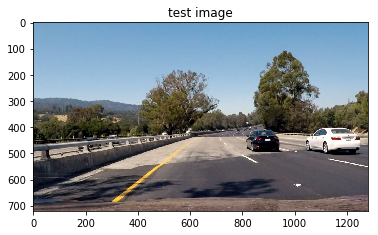

In [27]:
h = Helper()
img = h.load_image('../test_images/test4.jpg')
old_img = img
h.plot_image(old_img, 'test image')

corners found. please check self.imgpoints
stored calib coeffs @ ../data/calib_coeffs.pickle


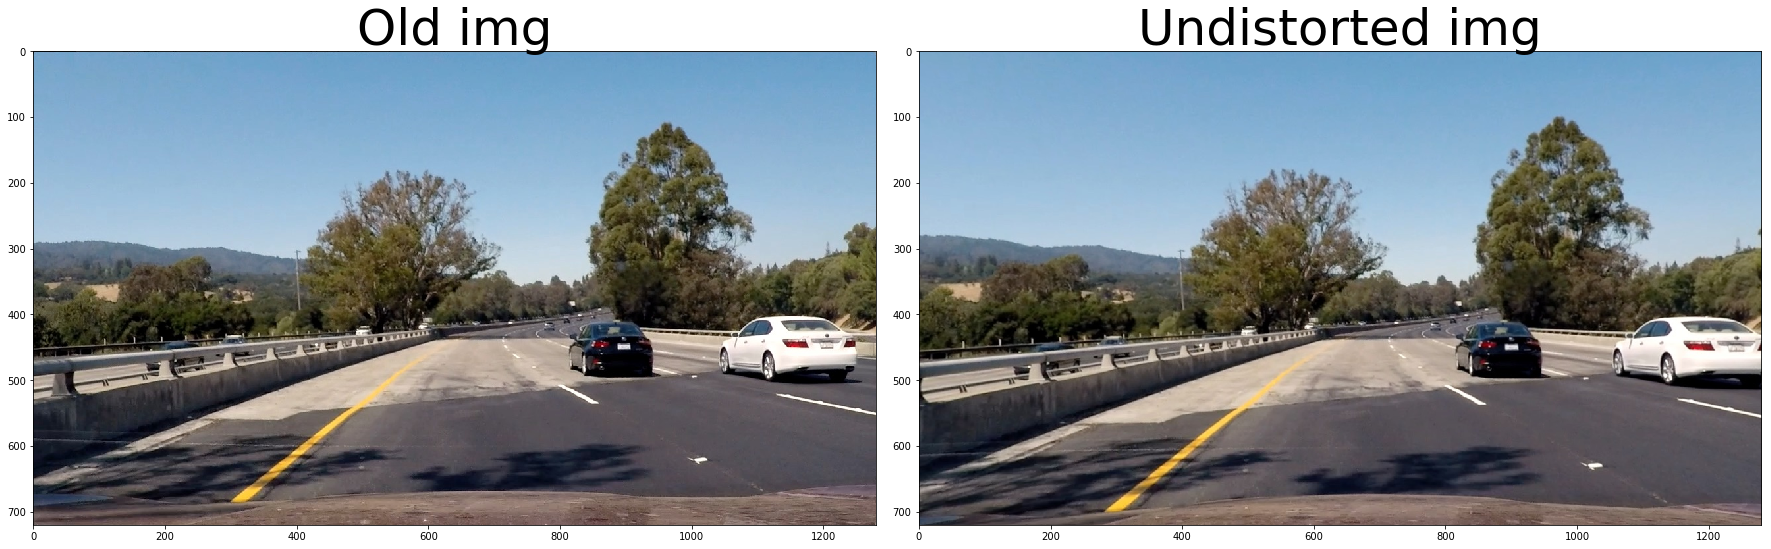

In [28]:
cal = Calibrator(x_corners=9, y_corners=6)

calib_images_path = '../camera_cal/*.jpg'
cal.compute_img_pts(calib_images_path, False)

test_image_path = '../camera_cal/calibration1.jpg'
cal.calibrate_camera(test_image_path)

cal.store_calib_coeffs('../data/calib_coeffs.pickle')

und_img = cal.undistort_image(img)
h.parallel_plots(img, 'Old img', und_img, 'Undistorted img')

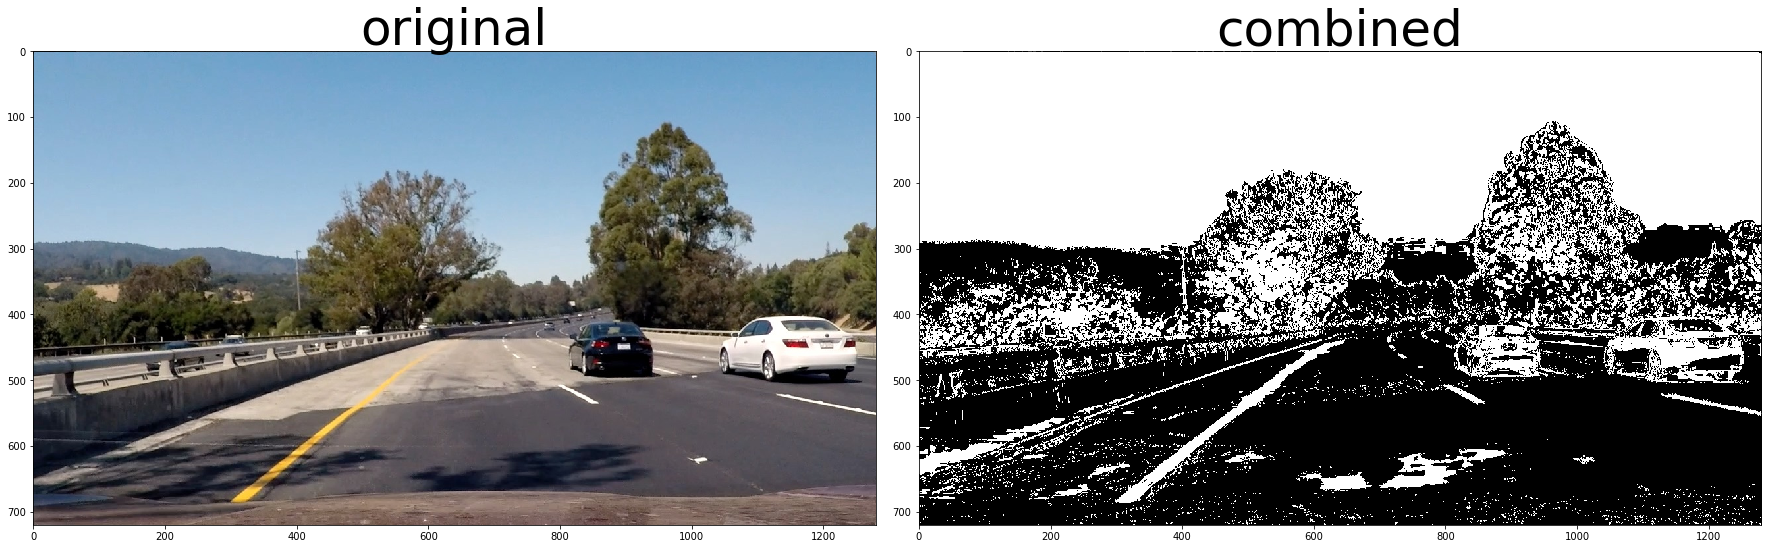

In [29]:
th = Thresholder()

ksize=3
s_thres = th.hls_threshold(img, thresh=(90, 255))
gradx = th.absolute_threshold(img, orient='x', thresh_min=20, thresh_max=100, sobel_kernel=ksize)
#grady = t.absolute_threshold(img, orient='y', thresh_min=20, thresh_max=100, sobel_kernel=ksize)
mag_binary = th.magnitude_threshold(img, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = th.direction_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

bin_img = np.zeros_like(dir_binary)
bin_img[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_thres == 1)] = 1
h.parallel_plots(img,'original', bin_img, 'combined', None, 'gray')

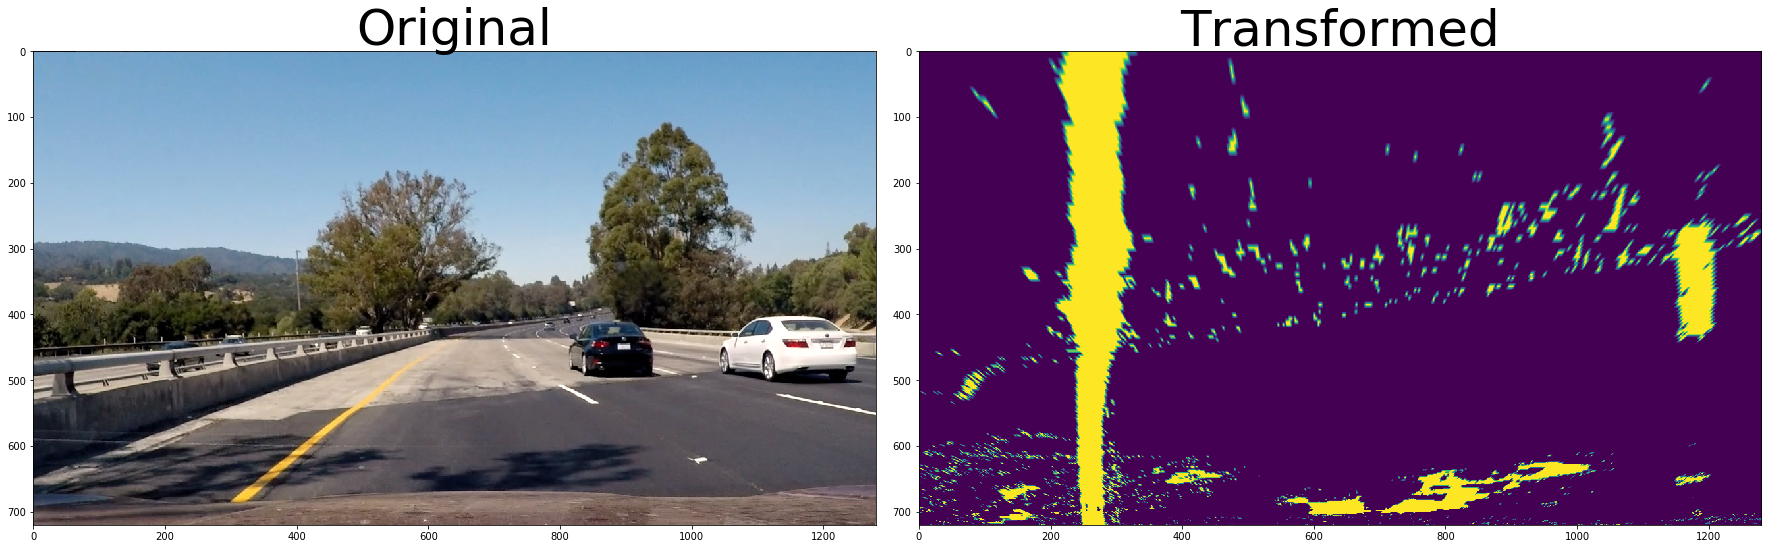

In [30]:
tr = Transformer()
corners = [(525, 499), (760, 499), (1047, 684), (253, 684)]
bin_warped = tr.transform(bin_img,corners , offset=200)

h.parallel_plots(img, 'Original', bin_warped, 'Transformed')

(1280,)

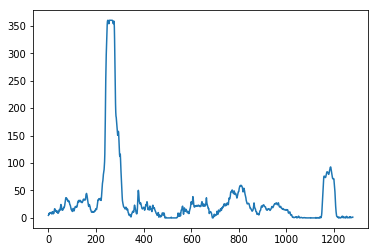

In [31]:
l = LaneFinder()
histogram = l.hist(bin_warped)
plt.plot(histogram)
histogram.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


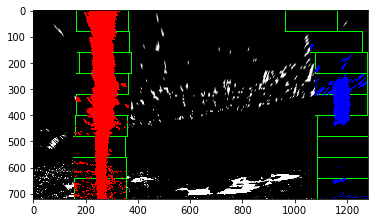

In [32]:
img, fits = l.fit_polynomial(bin_warped)
plt.imshow(img)

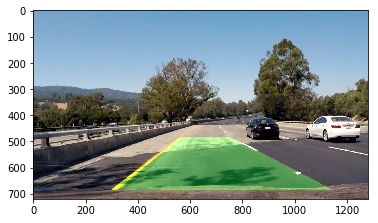

In [33]:
plt.imshow(l.overlay_lane(old_img, l.left_fit, l.right_fit, tr))

In [9]:
def pp(img):

    #Undistort Image
    und_img = cal.undistort_image(img)
    
    #Threshold the image
    ksize=3
    s_thres = th.hls_threshold(und_img, thresh=(90, 255))
    gradx = th.absolute_threshold(und_img, orient='x', thresh_min=20, thresh_max=100, sobel_kernel=ksize)
    #grady = t.absolute_threshold(img, orient='y', thresh_min=20, thresh_max=100, sobel_kernel=ksize)
    mag_binary = th.magnitude_threshold(und_img, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = th.direction_threshold(und_img, sobel_kernel=ksize, thresh=(0.7, 1.3))

    bin_img = np.zeros_like(dir_binary)
    bin_img[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_thres == 1)] = 1
    
    #Perspective transform
    corners = [(525, 499), (760, 499), (1047, 684), (253, 684)]
    bin_warped = tr.transform(bin_img,corners , offset=200)
    
    #Fit lane
    l.fit_polynomial(bin_warped)
    
    #overlay lane
    result = l.overlay_lane(und_img, l.left_fit, l.right_fit, tr)
    
    return result
    

In [11]:
clip1 = VideoFileClip('../project_video.mp4')
video_clip = clip1.fl_image(pp)
video_clip.write_videofile('tmo_op.mp4', audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video tmo_op.mp4.
Moviepy - Writing video tmo_op.mp4



Moviepy - Done !
Moviepy - video ready tmo_op.mp4


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

from helper import Helper
from thresholder import Thresholder
from calibrator import Calibrator
from transformer import Transformer
from lane_finder import LaneFinder

class PipeLine:
    def __init__(self, debug=False):
        
        self.calib_images_path = '../camera_cal/*.jpg'
        self.test_image_path = '../camera_cal/calibration1.jpg'
        self.coeffs_path = '../data/calib_coeffs.pickle'
        
        self.cal = self.calibrate_pipeline()
        
        self.h = Helper()  

        
        self.th = Thresholder()
        self.tr = Transformer()
        self.lane_finder = LaneFinder()        
        
        self.debug = debug
        
        
    def calibrate_pipeline(self):
        cal = Calibrator(x_corners=9, y_corners=6)

        cal.compute_img_pts(self.calib_images_path, False)
    
        cal.calibrate_camera(self.test_image_path)

        cal.store_calib_coeffs(self.coeffs_path)

        return cal
    
    def extract_lanes(self, img):

        self.original_img = img
        
        #Calibrate and Undistort
        self.und_img = self.cal.undistort_image(self.original_img)
        
        if self.debug:
            self.h.parallel_plots(self.original_img, 'Old img', self.und_img, 'Undistorted img') 
        
        
        #HYPER_PARAMS for Thresholding
        ksize=3
        s_thres = self.th.hls_threshold(self.und_img, thresh=(90, 255))
        gradx = self.th.absolute_threshold(self.und_img, orient='x', thresh_min=20, thresh_max=100, sobel_kernel=ksize)
        mag_binary = self.th.magnitude_threshold(self.und_img, sobel_kernel=ksize, mag_thresh=(20, 100))
        dir_binary = self.th.direction_threshold(self.und_img, sobel_kernel=ksize, thresh=(0.7, 1.3))

        self.bin_img = np.zeros_like(dir_binary)
        self.bin_img[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_thres == 1)] = 1
        
        if self.debug:
            self.h.parallel_plots(self.original_img,'original', self.bin_img, 'combined', None, 'gray')
        
        
        #HYPER_PARAMS for Transforming        
        corners = [(525, 499), (760, 499), (1047, 684), (253, 684)]        
        self.bin_warped = self.tr.transform(self.bin_img,corners , offset=200)

        if self.debug:
            self.h.parallel_plots(self.original_img, 'Original', self.bin_warped, 'Transformed')
        
        histogram = self.lane_finder.hist(self.bin_warped)
        if self.debug:
            plt.plot(histogram)     
            plt.show()
    
        if self.lane_finder.left_fit is None or self.lane_finder.right_fit is None:
            self.poly_fit_img, _ = self.lane_finder.fit_polynomial(self.bin_warped)
        else:
            self.poly_fit_img, _ = self.lane_finder.search_around_poly(self.bin_warped, \
                                                                       self.lane_finder.left_fit, \
                                                                       self.lane_finder.right_fit)
            
        if self.debug:
            plt.imshow(self.poly_fit_img)
        
        self.result = self.lane_finder.overlay_lane(self.original_img, self.lane_finder.left_fit, self.lane_finder.right_fit, self.tr)
        if self.debug:
            plt.imshow(self.result)
        
        return self.result

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [11]:
p = PipeLine(debug=False)

root_dir = '../'
fname = 'challenge_video.mp4'
clip = VideoFileClip(root_dir + fname)
#clip1 = clip1.subclip(40, 42)
video_clip = clip.fl_image(p.extract_lanes)
video_clip.write_videofile('out_' + fname, audio=False)

corners found. please check self.imgpoints
stored calib coeffs @ ../data/calib_coeffs.pickle


t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video out_challenge_video.mp4.
Moviepy - Writing video out_challenge_video.mp4




t:  26%|██▌       | 126/485 [02:25<03:10,  1.89it/s, now=None]


t:  52%|█████▏    | 250/485 [04:12<03:22,  1.16it/s, now=None]


t:  77%|███████▋  | 374/485 [06:08<01:38,  1.12it/s, now=None]


t:   2%|▏         | 25/1260 [38:09<15:39,  1.31it/s, now=None]

Moviepy - Done !
Moviepy - video ready out_challenge_video.mp4
